# Logistic Regression Problem Formulation

### 1. Goal
> Predict whether a car is **American-made** (`origin = 1`) or **foreign-made** (`origin = 2 or 3`) using its technical specifications.

### 2. Problem Statement
> We want to classify cars as either American or foreign based on features such as `cylinders`, `displacement`, `horsepower`, `weight`, and `acceleration`. This is a binary classification task where the target variable is derived from the `origin` column.

### 3. Target Variable
- Original column: `origin`
- Transformed binary label:
  - `1` → American-made
  - `0` → Foreign-made (Europe or Japan)

### 4. Input Features
- `cylinders`
- `displacement`
- `horsepower`
- `weight`
- `acceleration`

These reflect that engine size, power, and design choices may differ by region.

### 5. Hypotheses
- **Null Hypothesis (H₀)**: None of the selected features significantly influence whether a car is American-made. All coefficients are zero.
- **Alternative Hypothesis (H₁)**: At least one of the selected features significantly influences the likelihood that a car is American-made.

### 6. Example Input
```csv
cylinders, displacement, horsepower, weight, acceleration
4,113,95,2372,15
```

### 7. Predicted Output
```csv
0 → Foreign-made
```

## The expected approach involves:

1. Formulating the Model: Defining the linear combination of features and the sigmoid function.

2. Using Gradient Descent: This is the standard optimization algorithm used to train the Logistic Regression model (just as it is used to train DNNs).

3. Using the Sigmoid Function: This is the link function that maps the linear output to a probability between 0 and 1.

4. Using the Log-Loss (Cross-Entropy) Function: This is the standard cost function for classification tasks like this.

In [2]:
import pandas as pd

# Load the dataset
original_data = pd.read_csv("cars.csv")

# Clean the data (Removes the rows with '?')
data = original_data[original_data['horsepower'] != '?'].copy()

# 2. Convert to numeric (as they were stored as object since pd.read_csv() because of the '?')
data['horsepower'] = pd.to_numeric(data['horsepower'])

# Create a new binary column based on the rule
# This sets the new column to 1 (True) wherever 'origin' is 1
# And 0 (False) otherwise. Pandas/NumPy automatically converts True/False to 1/0.
data['origin_binary'] = (data['origin'] == 1).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mpg            392 non-null    float64
 1   cylinders      392 non-null    int64  
 2   displacement   392 non-null    float64
 3   horsepower     392 non-null    int64  
 4   weight         392 non-null    int64  
 5   acceleration   392 non-null    float64
 6   model year     392 non-null    int64  
 7   origin         392 non-null    int64  
 8   car name       392 non-null    object 
 9   origin_binary  392 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 33.7+ KB


In [3]:
from sklearn.model_selection import train_test_split

# Assuming 'data' DataFrame exists and 'origin_binary' is created
feature_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
target_col = 'origin_binary'

X = data[feature_cols].values
y = data[target_col].values

# First Split: Separate out the Test set (15%)
# Using train_test_split for automatic shuffling of data before splitting
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Second Split: Separate the remaining data (X_temp) into Train (70%) and Validation (15%)
# Since X_temp is 85% of the original data, 15% of the original data is 
# approximately (0.15 / 0.85) of X_temp, which is ~0.176.
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=(0.15 / 0.85), random_state=42
)

# Check sizes (will be close to 70/15/15)
print(f"Train size: {len(X_train)} ({len(X_train)/len(X):.2f})")
print(f"Validation size: {len(X_val)} ({len(X_val)/len(X):.2f})")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X):.2f})")
X_train


Train size: 274 (0.70)
Validation size: 59 (0.15)
Test size: 59 (0.15)


array([[4.000e+00, 9.700e+01, 8.800e+01, 2.100e+03, 1.650e+01],
       [6.000e+00, 2.250e+02, 1.000e+02, 3.233e+03, 1.540e+01],
       [4.000e+00, 1.400e+02, 7.500e+01, 2.542e+03, 1.700e+01],
       ...,
       [8.000e+00, 4.000e+02, 1.900e+02, 4.422e+03, 1.250e+01],
       [8.000e+00, 3.500e+02, 1.800e+02, 4.499e+03, 1.250e+01],
       [4.000e+00, 7.800e+01, 5.200e+01, 1.985e+03, 1.940e+01]],
      shape=(274, 5))

In [4]:
# Apply scaling and bias
from sklearn.preprocessing import StandardScaler
import numpy as np 

# --- Feature Scaling ---
scaler = StandardScaler()

# 1. Fit the scaler ONLY on the training data.
scaler.fit(X_train)

# 2. Transform ALL three sets using the training set's statistics.
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Trying to fine tune the model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Create the logistic regression model
model = LogisticRegression(
    penalty=None,         # No regularization to match your custom cost
    solver='lbfgs',         # Solver that supports no regularization
    max_iter=50,         # Matches your iterations
    verbose=0,               # Set to 1 if you want logs
    tol=1e-2,
)

# Fit the model to your training data
model.fit(X_train_scaled, y_train)
print("Actual iterations:", model.n_iter_)

# Access learned parameters
theta_final = model.coef_        # Shape: (1, n_features)
bias = model.intercept_          # Shape: (1,)

# ------------------------------------------------------------------------
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

y_val_pred = model.predict(X_val_scaled)
y_val_proba = model.predict_proba(X_val_scaled)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Log-loss:", log_loss(y_val, y_val_proba))
print("ROC AUC:", roc_auc_score(y_val, y_val_proba[:, 1]))

scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Mean ROC AUC (CV):", scores.mean())

Actual iterations: [10]
Accuracy: 0.864406779661017
Log-loss: 0.2768888609405282
ROC AUC: 0.9456521739130435
Mean ROC AUC (CV): 0.9434653299916457


### Evaluating on Test Set

In [6]:
# Predict on test set
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)

# Evaluate
test_accuracy = accuracy_score(y_test, y_test_pred)
test_log_loss = log_loss(y_test, y_test_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba[:, 1])

# Print results
print("Test Accuracy:", test_accuracy)
print("Test Log-loss:", test_log_loss)
print("Test ROC AUC:", test_roc_auc)

Test Accuracy: 0.8813559322033898
Test Log-loss: 0.26942451373635695
Test ROC AUC: 0.9285714285714286


In [7]:
print(f"{'Set':<10} {'Accuracy':<10} {'Log-loss':<15} {'ROC AUC':<10}")
print(f"{'Train':<10} {accuracy_score(y_train, model.predict(X_train_scaled)):<10.4f} {log_loss(y_train, model.predict_proba(X_train_scaled)):<15.4f} {roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1]):<10.4f}")
print(f"{'Val':<10} {accuracy_score(y_val, y_val_pred):<10.4f} {log_loss(y_val, y_val_proba):<15.4f} {roc_auc_score(y_val, y_val_proba[:, 1]):<10.4f}")
print(f"{'Test':<10} {test_accuracy:<10.4f} {test_log_loss:<15.4f} {test_roc_auc:<10.4f}")

Set        Accuracy   Log-loss        ROC AUC   
Train      0.8832     0.2600          0.9502    
Val        0.8644     0.2769          0.9457    
Test       0.8814     0.2694          0.9286    


### Using the model for predictions

In [39]:
# Example input: a new car's features (already scaled)
new_car_raw = [[8,225,225,3786,10]]  # cylinders, displacement, horsepower, weight, acceleration

new_car_scaled = scaler.transform(new_car_raw)

# Predict class (0 or 1)
is_american = model.predict(new_car_scaled)
print("Predicted class:", is_american)

# Predict probability
proba = model.predict_proba(new_car_scaled)
print("Probability of being American-made:", proba[0][1])

Predicted class: [0]
Probability of being American-made: 0.02946429938537933


### Answering the hypothesis

In [33]:
# Derive feature names: prefer explicit feature_cols if present, otherwise infer
if 'feature_cols' in globals():
    feature_names = feature_cols
elif isinstance(X_train, pd.DataFrame):
    feature_names = list(X_train.columns)
else:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

# Get coefficients
coefficients = model.coef_[0]

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print(coef_df)

        Feature  Coefficient
1  displacement    11.661796
4  acceleration    -0.165555
0     cylinders    -1.282278
3        weight    -1.803106
2    horsepower    -2.587725


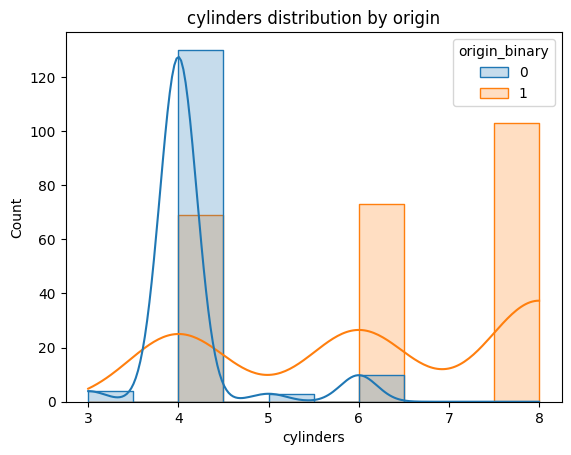

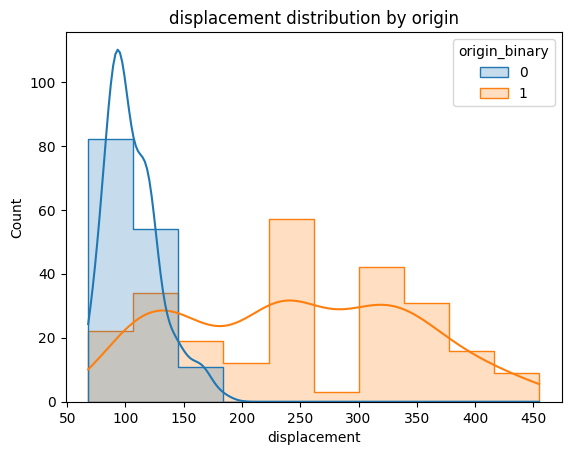

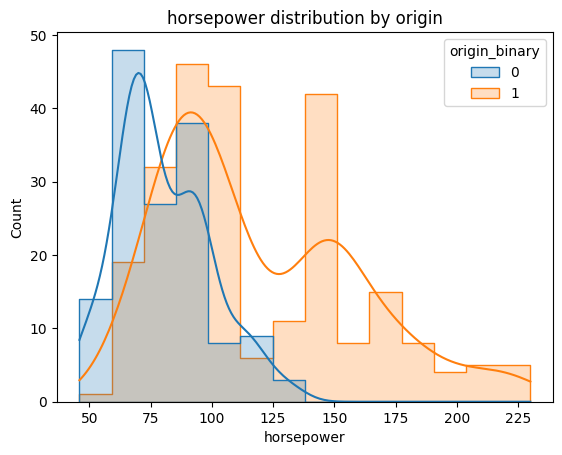

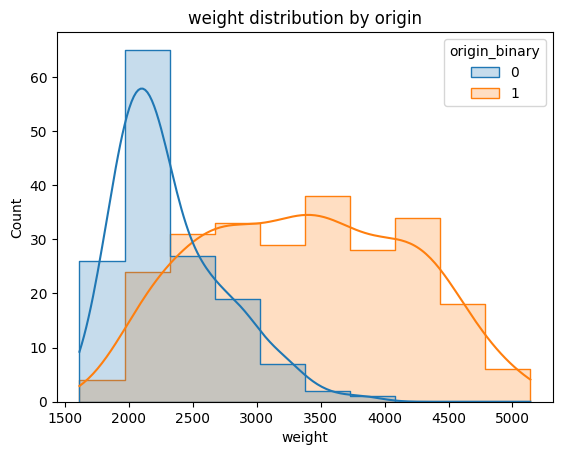

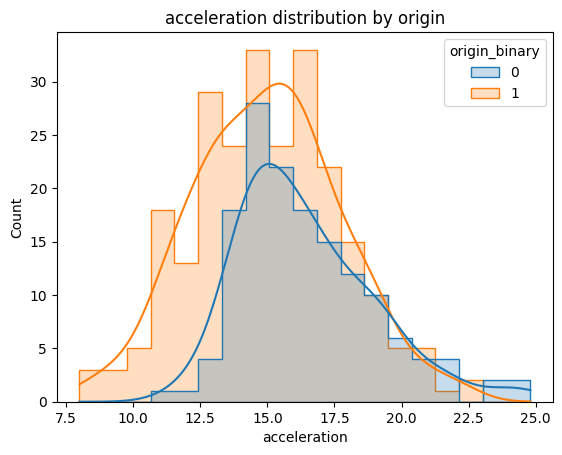

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in feature_names:
    sns.histplot(data=data, x=feature, hue='origin_binary', kde=True, element='step')
    plt.title(f"{feature} distribution by origin")
    plt.show()